# Spencer Hallyburton, Salvador Barragan

# APMTH 207: Advanced Scientific Computing: 
## Stochastic Methods for Data Analysis, Inference and Optimization
## Final

**Harvard University**<br>
**Spring 2018**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Saturday, May 12th, 2018 at 11:59am

# Q1: GLMs with correlation

In Homework 10 you examined the effects of educational attainment and gender on the probability that an indivudal would earn more than $50K per year. However, even the models in the solutions (see Canvas) didn't achieve a perfect fit. Perhaps there was something missing?

## The dataset: A Study of Census Data

In this problem, we are reprising our investigation into the data from the 1994 U.S. Census. The data has been processed so that only a subset of the features are present (for full dataset as well as the description see the UCI Machine Learning Repository).

We'll again want to aggregate the dataset into seven different categories. The categories we wish to consider are:

- 4 year college degree
- Some-college or two year academic college degree
- High school
- Professional, vocational school
- Masters
- Doctorate
- Some or no high school 

Note that we had to combine some of the existing education categories in your dataframe. For each category, we kept track of a count of the number of males and females who make above (and resp. below) $50k

We provide the code below so that all students begin with the same data structure, names, and global parameters.

In [136]:
import pymc3 as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from theano import tensor as tt

In [137]:
df = pd.read_csv('census_data.csv')
df.head()

cat_1 = ['11th', '7th-8th', '9th', '5th-6th', '10th', '1st-4th', 'Preschool', '12th']
cat_2 = ['HS-grad']
cat_3 = ['Some-college', 'Assoc-acdm']
cat_4 = ['Assoc-voc', 'Prof-school']
cat_5 = ['Bachelors']
cat_6 = ['Masters']
cat_7 = ['Doctorate']

labels = ["Some HS", "HS Grad", "Some College", "Prof School", "Bachelors", "Masters", "Doctorate"]

categories = [cat_1, cat_2, cat_3, cat_4, cat_5, cat_6, cat_7]
dataset = []
i = 1
for cat in categories:
    filtered = df[df['edu'].isin(cat)]
    dataset.append((i, 0, len(filtered[filtered['sex'] == 'Female']), len(filtered[(filtered['sex'] == 'Female') & (filtered['earning'] == '<=50K')]), len(filtered[(filtered['sex'] == 'Female') & (filtered['earning'] == '>50K')])))
    dataset.append((i, 1, len(filtered[filtered['sex'] == 'Male']), len(filtered[(filtered['sex'] == 'Male') & (filtered['earning'] == '<=50K')]), len(filtered[(filtered['sex'] == 'Male') & (filtered['earning'] == '>50K')])))
    i += 1
dataset = np.array(dataset)
dataset = pd.DataFrame(dataset, columns=['edu', 'sex', 'total', '<=50', '>50'])
dataset['edu'] = dataset['edu']-1 #zero indexing
dataset

,edu,sex,total,<=50,>50
0,0,0,1321,1298,23
1,0,1,2932,2711,221
2,1,0,3390,3164,226
3,1,1,7111,5662,1449
4,2,0,3227,2974,253
5,2,1,5131,3732,1399
6,3,0,592,483,109
7,3,1,1366,691,675
8,4,0,1619,1280,339
9,4,1,3736,1854,1882


## Part A: Model 1

In Chapter 13.2 McElreath iterates on his model for the UCB admissions data. (See the attached PDF of that section. We have included pdfs of excerpts from McElreath sections 10.1.3 and 13.2)

**A1**: Implement the upgraded model from section 13.2.1 on the income data. You may refer to Osvaldo Martin's pymc3 implementation of Statistical Rethinking if needed.

In [138]:
burnin=500
ssize = 10000
tune = 500

In [139]:
Nedu = len(categories)

with pm.Model() as edu_gender_13_2_1:
    # Set up the model
    a = pm.Normal('a',0, 10)
    bm = pm.Normal('bm',0, 1)
    sigma = pm.HalfCauchy('sigma', 2)
    alpha_ed = pm.Normal('alpha_ed', a, sigma, shape=Nedu)
    p = pm.math.invlogit(alpha_ed[dataset['edu']] + bm*dataset['sex'])
    income = pm.Binomial('income', p=p, n=dataset['total'], observed=dataset['>50'])

**A2**: You will notice here that the $\alpha$s at different income levels are pooled

1. What criterion do you use to tell if full, partial, or no pooling is appropriate to the given data? 

**NEED ANSWER HERE**

2. Which type of pooling is implemented here. Why is it most appropriate to our income data?

**NEED ANSWER HERE**

**A3**: Sample from the model's posterior and comment on the quality of the samples obtained, examining at least two of the diagnostics discussed in class.

\[Sampling this model took 2 minutes and 30 seconds per chain (~80 it/s) on a VM running on old hardware.\]

In [140]:
# Sample the models
map1 = pm.find_MAP(model=edu_gender_13_2_1)

with edu_gender_13_2_1:
    stepper = pm.NUTS()
    traces_edu_13_2_1 = pm.sample(ssize, step=stepper, tune=tune, chains=3, start=map1)

logp = -71.454, ||grad|| = 0.40208: 100%|██████████| 48/48 [00:00<00:00, 461.06it/s]  
Multiprocess sampling (3 chains in 2 jobs)
NUTS: [alpha_ed, sigma_log__, bm, a]
100%|██████████| 10500/10500 [00:35<00:00, 296.03it/s]


In [141]:
traces_edu_13_2_1

<MultiTrace: 3 chains, 10000 iterations, 5 variables>

In [142]:
# Show summary plot
pm.summary(traces_edu_13_2_1).round(3)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,-1.762,0.621,0.004,-2.967,-0.495,24861.0,1.0
bm,1.370,0.036,0.000,1.301,1.442,11641.0,1.0
alpha_ed__0,-3.891,0.074,0.000,-4.038,-3.749,26389.0,1.0
alpha_ed__1,-2.719,0.041,0.000,-2.800,-2.639,15391.0,1.0
alpha_ed__2,-2.373,0.040,0.000,-2.450,-2.294,16040.0,1.0
alpha_ed__3,-1.414,0.056,0.000,-1.524,-1.307,22887.0,1.0
alpha_ed__4,-1.350,0.041,0.000,-1.427,-1.268,16624.0,1.0
alpha_ed__5,-0.712,0.057,0.000,-0.823,-0.600,27138.0,1.0
alpha_ed__6,0.021,0.119,0.001,-0.209,0.258,30000.0,1.0
sigma,1.546,0.531,0.004,0.765,2.580,20417.0,1.0


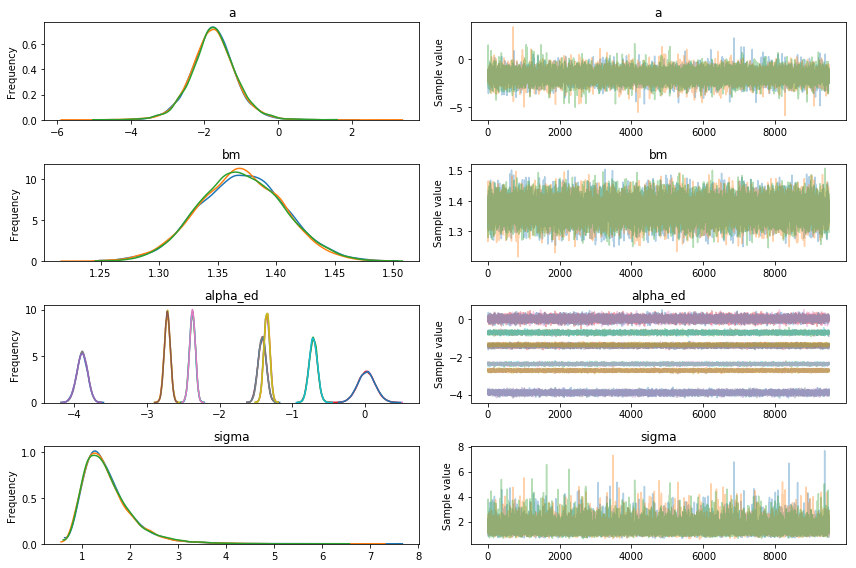

In [143]:
pm.traceplot(traces_edu_13_2_1[burnin:]);

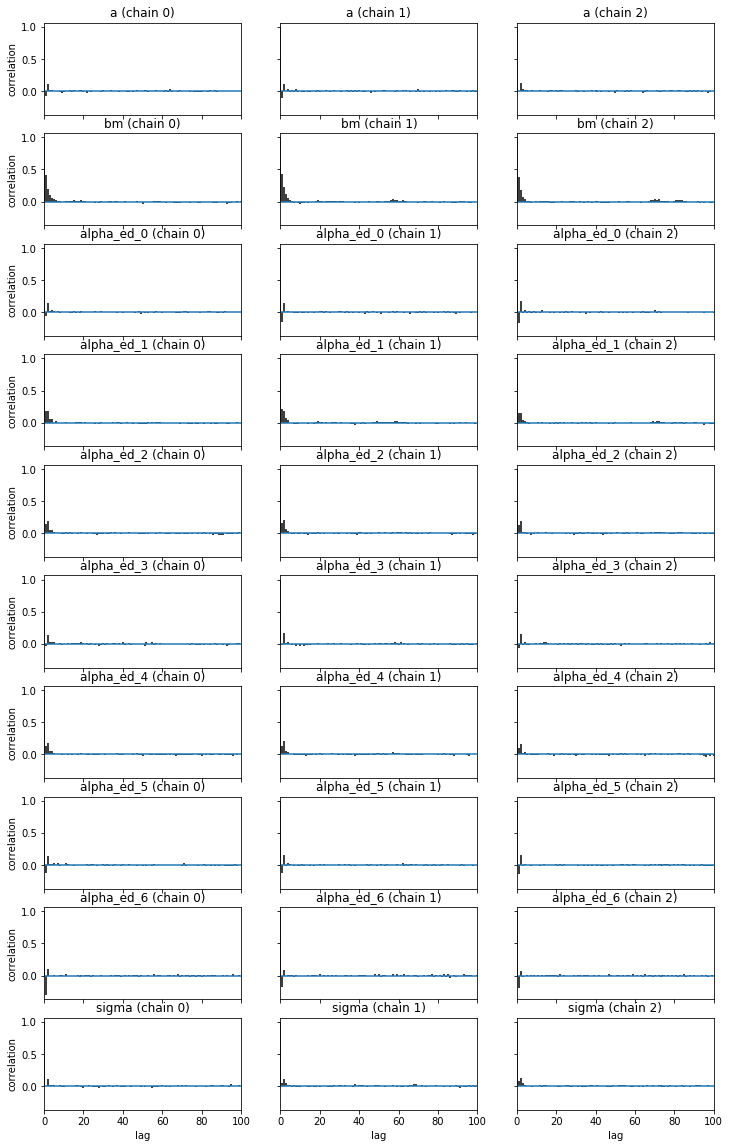

In [144]:
pm.autocorrplot(traces_edu_13_2_1[burnin:]);

In [145]:
traces_edu_13_2_1.varnames

['a', 'bm', 'sigma_log__', 'alpha_ed', 'sigma']

In [146]:
# 1. Gelman Rubin Statistic
pm.gelman_rubin(traces_edu_13_2_1)

{'a': 0.99998271784781712,
 'alpha_ed': array([ 1.00008721,  1.00030744,  1.00010282,  1.00005012,  1.00011562,
         0.99998368,  0.99995221]),
 'bm': 1.0001151524629199,
 'sigma': 0.99997655576143107}

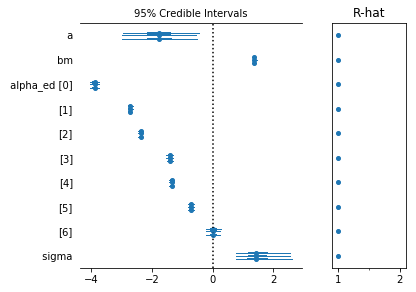

In [147]:
pm.forestplot(traces_edu_13_2_1)

The Gelman-Rubin statistic uses the fact of multiple chains to check if the sampling has converged. If there is convergence, we expect different chains to look very similar to one another, and the Gelman Rubin statistic checks for that. A value close to 1.0 indicates that sampling has converged and the chains look like each other. We see in the above results that all of the Gelman Rubin statistics are close to 1.0, indicating that our sampling did in fact converge. We can then use the Forest Plot function to get a sense of the behavior of each of the variables in our model. We see that hte Rhat values are very close to 1.0 and the 95% credible intervals are pretty tight along most of the parameters of the model.

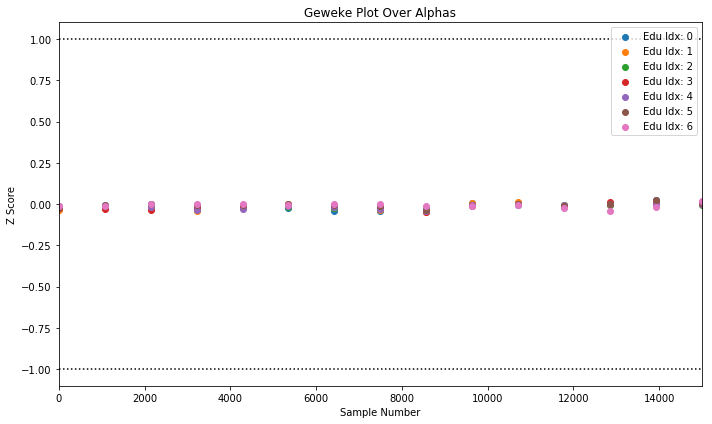

In [152]:
# 2. Geweke Statistic
plt.figure(figsize=(10,6))

z = pm.geweke(traces_edu_13_2_1['alpha_ed'], intervals=15)
for edu_idx in range(len(z)):
    plt.scatter(*z[edu_idx].T, label=r'Edu Idx: %d'%edu_idx)
    
plt.hlines([-1,1], 0, 15000, linestyles='dotted')
plt.xlim(0,15000)
plt.title('Geweke Plot Over Alphas')
plt.xlabel('Sample Number')
plt.ylabel('Z Score')
plt.legend()
plt.tight_layout()
plt.show()

The Geweke statistic compares the mean and variance of different segments in certain intervals of a single chain. You can find the equation online somewhere. If the z scores of different segments of the chain are similar, then we operate under the assumption that the sampler has converged. We see in the above figure that, over the number of samples, we do get a convergence of our chains.

In [13]:
# Sample from posterior using sample ppc
with edu_gender_13_2_1:
    ppc_edu_13_2_1 = pm.sample_ppc(traces_edu_13_2_1)

100%|██████████| 10000/10000 [00:03<00:00, 2545.59it/s]


In [14]:
# CITATION: The following code was adapted from the solution set to HW 10 from this course.
# Posterior validation function
def plot_post_validation_check(ax, dataset, ppc_obs, labels, title=""):
    
    above_50k = dataset['>50']
    total = dataset['total']
    
    color_map = plt.cm.get_cmap("viridis")
    upper_quantile = np.percentile(ppc_obs, 89, axis=0)
    lower_quantile = np.percentile(ppc_obs, 11, axis=0)

    for i in range(0, 7):
        ax.plot([2*i], (above_50k/ total)[2*i], color= 'darkred', alpha=0.4, marker='H', linestyle='None')
        ax.plot([2*i+1], (above_50k/ total)[2*i+1], color= 'darkblue', alpha=0.4, marker='H', linestyle='None')

        ax.plot([2*i, 2*i+1], (above_50k/ total)[2*i:2*i+2], color = color_map(2/7), linestyle='-')
        
        ax.text(2*i+ 0.6, np.mean((above_50k/total)[2*i:2*i+2]), labels[i],  color = color_map(2/7), ha='left', va='top')
        
        # plot ppc means
        ax.plot([2*i], (ppc_obs.mean(axis=0)/ total)[2*i], color= 'darkred', alpha=0.4, marker='*', linestyle='None')
        ax.plot([2*i+1], (ppc_obs.mean(axis=0)/ total)[2*i+1], color= 'darkblue', alpha=0.4, marker='*', linestyle='None')

        
        # plot percentiles
        ax.plot([2*i], (upper_quantile/total)[2*i], color= 'darkred', alpha=0.4, marker='^', linestyle='None')
        ax.plot([2*i], (lower_quantile/total)[2*i], color= 'darkred', alpha=0.4, marker='v', linestyle='None')

        ax.plot([2*i+1], (upper_quantile/total)[2*i+1], color= 'darkblue',alpha=0.4, marker='^', linestyle='None')
        ax.plot([2*i+1], (lower_quantile/total)[2*i+1], color= 'darkblue',alpha=0.4, marker='v', linestyle='None')
        

    ax.set_xlim((-0.5, 13.5))
    ax.set_ylim((0, 1))
    ax.set_title("Posterior Validation Check - " + title)
    ax.set_ylabel("Proportion > \$50k")

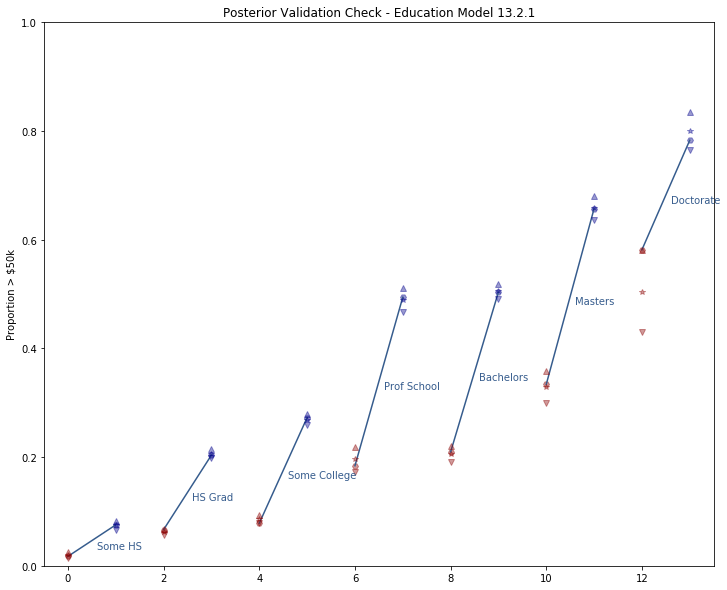

In [15]:
fig, ax = plt.subplots(figsize=(12, 10))
plot_post_validation_check(ax, dataset, ppc_edu_13_2_1['income'], labels, "Education Model 13.2.1")

**A4**: Use the code below to plot the amount of shrinkage in our model. Think carefully about what quantity in the dataset and in the posterior you ought to compare. You should see minimal shrinkage in all categories except the last one.

In [16]:
def shrinkage_plot(observed_log_odds, posterior_means, posterior_sds):
    """
    observed_log_odds - an entry for each category giving the actual log-odds observed log(P(>50K)/(1-P(>50K)))
    posterior_means - an entry for each category giving the mean of the posterior distribution
    posterior_sds - an entry for each category giving the SD of the posterior distribution
    """
    plt.scatter(range(len(observed_log_odds)),observed_log_odds, label="Observed Log Odds", color='orange')
    plt.errorbar(range(len(posterior_means)), posterior_means, yerr = 2*posterior_sds, fmt='o', label="Posterior for Log Odds\n(mean and 2 SDs)",)
    plt.legend()
    plt.xlabel("Education Category")

In [17]:
# Get the observed log odds:
obs_log_odds = np.log(dataset['>50'] / dataset['<=50']).values

In [18]:
obs_log_odds

array([-4.03308568, -2.50691015, -2.63905733, -1.36290352, -2.46427364,
       -0.98118659, -1.48866877, -0.02342713, -1.32861525,  0.01498957,
       -0.69034998,  0.65048073,  0.32850407,  1.28249757])

In [20]:
# Get the posterior means
p_male = traces_edu_13_2_1['alpha_ed'] + traces_edu_13_2_1['bm'][:, np.newaxis]
p_female = traces_edu_13_2_1['alpha_ed'] 

# Calculate means and stds
p_male_mean = np.mean(p_male,axis=0)
p_male_sd = np.std(p_male,axis=0)
p_female_mean = np.mean(p_female,axis=0)
p_female_sd = np.std(p_female, axis=0)

# Restack them
p_mean = [val for pair in zip(p_female_mean, p_male_mean) for val in pair]
p_sd = [val for pair in zip(p_female_sd, p_male_sd) for val in pair]

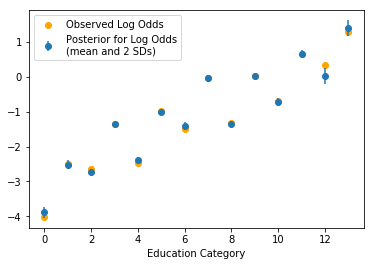

In [21]:
shrinkage_plot(np.array(obs_log_odds), np.array(p_mean), np.array(p_sd))

**A5**: McElreath's new model showed substantial shrinkage within the categories. Why does our model show very minimal shrinkage?. For full credit, include Standard Error in your explanation.

**SHIRINKAGE EXPLANATION**
DOES IT HAVE TO DO WITH POOLING?? "That's because there are a lot of applications on each row"

## Part B: Iterating further

After the pooling model above, McElreath builds a model where the alpha and beta in each unit might be correlated (perhaps the higher the admission rate, the less bias there is towards either gender). 

**B1**: Implement the model in 13.2.2. Feel free to use [code from Osvaldo Martin](https://github.com/aloctavodia/Statistical-Rethinking-with-Python-and-PyMC3/blob/master/Chp_13.ipynb) with attribution and understanding (it contains some sweet pymc3 technical wrangling).

The variable names in this model are unchanged and you may re-name them if you wish.

Note that this model builds the a 7 by 2 matrix with alpha values in the first column and beta values in the second. By assumption, the first column and the second column have correlation structure given by the LKJ prior, but there is no explicit correlation among the rows (aside from all the alphas coming from the same mean). In other words, the correlation matrix is 2x2 (not 14x14) and amongst the income-level-free parts of the intercept and slope.

In [26]:
# Code taken and adapted from Osvaldo Martin:
Nedu = len(categories)
edu_id = dataset['edu']
with pm.Model() as edu_gender_13_2_2:
    a = pm.Normal('a', 0, 10)
    b = pm.Normal('b', 0, 1)
    
    sd_dist = pm.HalfCauchy.dist(beta=2)
    packed_chol = pm.LKJCholeskyCov('chol_cov', eta=2, n=2, sd_dist=sd_dist)
    
    # compute the covariance matrix
    chol = pm.expand_packed_triangular(2, packed_chol, lower=True)
    cov = tt.dot(chol, chol.T)
    
    # Extract the standard deviations and rho
    sigma = pm.Deterministic('sigma', tt.sqrt(tt.diag(cov)))
    corr = tt.diag(sigma**-1).dot(cov.dot(tt.diag(sigma**-1)))
    r = pm.Deterministic('Rho', corr[np.triu_indices(2, k=1)])
    
    mu = pm.MvNormal('mu', mu=tt.stack([a, b]), cov=cov, shape=(Nedu, 2))
        
    alpha_ed = pm.Deterministic('alpha_ed', mu[:, 0])
    bm_ed = pm.Deterministic('bm_ed', mu[:, 1])
    
    p = pm.math.invlogit(mu[edu_id, 0] + mu[edu_id, 1] * dataset['>50'])
    income = pm.Binomial('income', p=p, n=dataset['total'], observed=dataset['>50'])

**B2**: Sample from the posterior of the model above *with a target acceptance rate of .9 or more*. (Sampling takes 10 minutes per chain on a VM on old hardware and 2 minutes 30 seconds on a recent-gen Mac). Analyze at least two diagnostics and comment on the quality of the samples obtained.

In [ ]:
# Find map estimate
map2 = pm.find_MAP(model=edu_gender_13_2_2)

In [130]:
# Sample the models
with edu_gender_13_2_2:
    stepper=pm.Metropolis()
    traces_13_2_2_preburn = pm.sample(5000, tune=200, step=stepper, start=map2, chains=2)
    #traces_13_2_2 = pm.sample(200, tune=200, step=stepper, start=map2, chains=2, nuts_kwargs={'target_accept':.9})

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [mu]
>Metropolis: [chol_cov_cholesky_cov_packed__]
>Metropolis: [b]
>Metropolis: [a]
100%|██████████| 5200/5200 [00:15<00:00, 330.37it/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [132]:
traces_13_2_2 = traces_13_2_2_preburn[burnin::]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1f84e978>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1c2951d208>]], dtype=object)

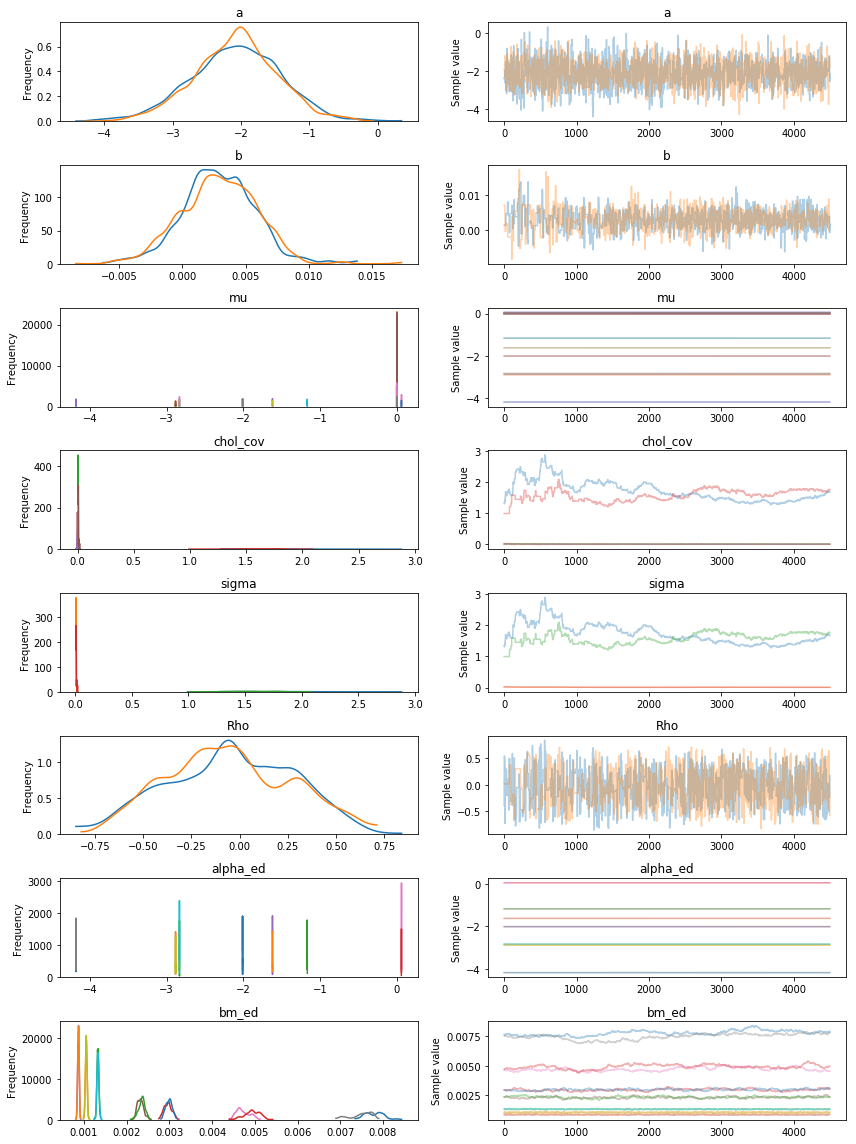

In [133]:
pm.traceplot(traces_13_2_2)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c25fd2d68>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1c2ab65470>]], dtype=object)

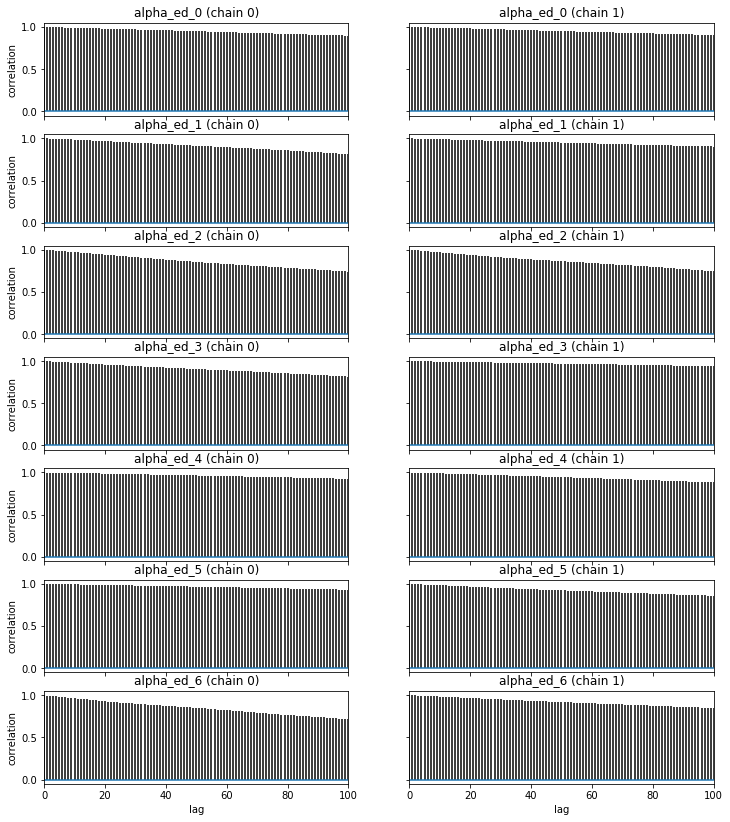

In [134]:
pm.autocorrplot(traces_13_2_2, varnames=['alpha_ed'])

Perform diagnostic checks:

In [50]:
# 1. Gelman Rubin Statistic
pm.gelman_rubin(traces_13_2_2)

{'Rho': array([ 1.00053347]),
 'a': 1.0004533446345421,
 'alpha_ed': array([ 1.26647855,  2.06360795,  1.15034512,  1.7462847 ,  1.6070462 ,
         2.69158631,  2.14770037]),
 'b': 1.0000042366840236,
 'bm_ed': array([ 1.00072229,  1.00428561,  1.00245394,  1.00730898,  0.99996333,
         1.01054736,  1.01643733]),
 'chol_cov': array([ 1.01507975,  0.99990035,  1.00009424]),
 'mu': array([[ 1.26647855,  1.00072229],
        [ 2.06360795,  1.00428561],
        [ 1.15034512,  1.00245394],
        [ 1.7462847 ,  1.00730898],
        [ 1.6070462 ,  0.99996333],
        [ 2.69158631,  1.01054736],
        [ 2.14770037,  1.01643733]]),
 'sigma': array([ 1.01507975,  1.00043282])}

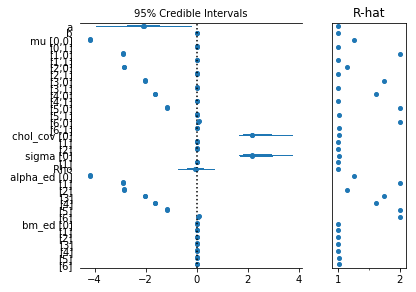

In [125]:
pm.forestplot(traces_13_2_2)

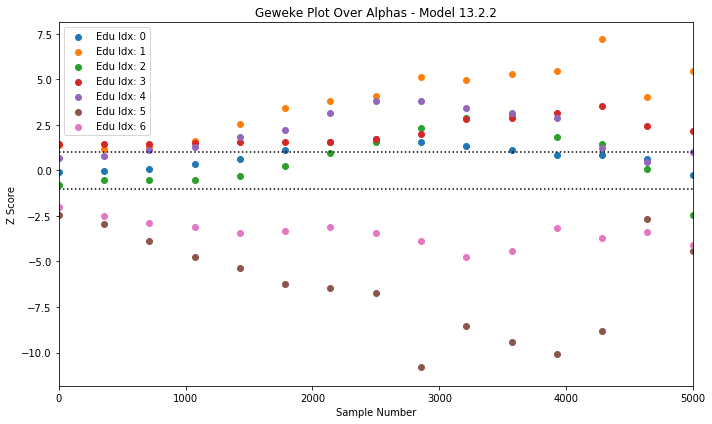

In [55]:
# 2. Geweke Statistic
plt.figure(figsize=(10,6))

z = pm.geweke(traces_13_2_2['alpha_ed'], intervals=15)
for edu_idx in range(len(z)):
    plt.scatter(*z[edu_idx].T, label=r'Edu Idx: %d'%edu_idx)
    
plt.hlines([-1,1], 0, 5000, linestyles='dotted')
plt.xlim(0,5000)
plt.title('Geweke Plot Over Alphas - Model 13.2.2')
plt.xlabel('Sample Number')
plt.ylabel('Z Score')
plt.legend()
plt.tight_layout()
plt.show()

**Comments on sample quality:** COMMENTS

**B3**: Propose at least two methods of improving the quality of the samples obtained and explain how/why each method would help. For **some extra credit** implement these. 

Improvement 1:

Improvement 2:

**B4**: Regardless of your answer above, assume the samples are valid and give an analysis of whether the data and models support the hypothesis that males are more advantaged in lower income categories than they are in higher income categories. For full credit, include at least one formal model comparison or probability analysis.

In [58]:
# Compute WAIC scores:
def make_compare(names, traces, models, ic='WAIC'):
    compared=pm.compare(traces,models, method='pseudo-BMA')
    temp=compared.sort_index()
    temp['Model']=names
    compared = temp.sort_values(ic).set_index('Model')
    return compared

In [59]:
# Compare the previous two models using WAIC statistics:
names=['Model 1', 'Model 2']
dfc=make_compare(names, [traces_edu_13_2_1, traces_13_2_2],[edu_gender_13_2_1, edu_gender_13_2_2])
dfc

,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
Model,,,,,,,
Model 2,112.45,2.67,0,1,6.9,0,1
Model 1,123.21,6.08,10.76,0,5.63,5.46,1


**B5**: Regardless of your answer above, assume the samples are valid and give an analysis of: 
1. The posterior probability that males with a Bachelor's degree are more likely to have high incomes than males with a Professional School degree (education categories 3 and 4) \[Specifically, how certain is it that one or the other class has a higher chance of having a high income?\]. 
2. The posterior-predictive on the number of female PhDs earning more than 50K in similarly sized samples

In [118]:
logp3_male

-2.0067078264658385

In [119]:
logp4_male

-1.6178818577815834

In [128]:
# 1. Certainty of one class having chance of higher income
# i) Get the probability values from the posterior

logp3_male = np.mean(traces_13_2_2['alpha_ed'][:,3] + traces_13_2_2['bm_ed'][:,3])
logp4_male = np.mean(traces_13_2_2['alpha_ed'][:,4] + traces_13_2_2['bm_ed'][:,4])

# ii) Get the difference in this log p
print('Posterior Probability of Bachelors>Professional: %.3f%%' % (np.exp(logp4_male - logp3_male)*100))

Posterior Probability of Bachelors>Professional: 147.525%


In [ ]:
# Sample the posterior predictive on the full set of data
with edu_gender_13_2_2:
    ppc_edu_13_2_2 = pm.sample_ppc(traces_13_2_2, samples=1000)

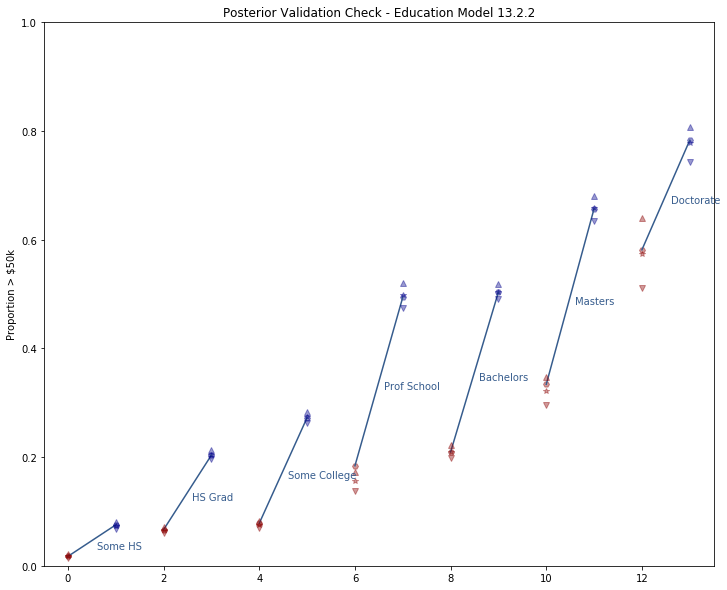

In [73]:
fig, ax = plt.subplots(figsize=(12, 10))
plot_post_validation_check(ax, dataset, ppc_edu_13_2_2['income'], labels, "Education Model 13.2.2")

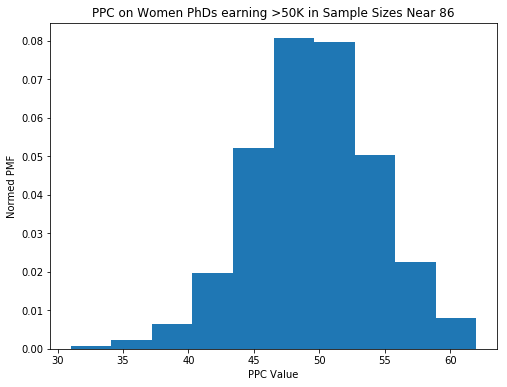

In [129]:
# 2. Posterior predictive on number of female PhDs earning more than 50K
cat = 12

# Plot a histogram of the ppc of the women PhDs earning more than 50K
fig = plt.figure(figsize=(8, 6))
plt.hist(ppc_edu_13_2_2['income'][:,cat], normed=True)
plt.title('PPC on Women PhDs earning >50K in Sample Sizes Near 86')
plt.xlabel('PPC Value')
plt.ylabel('Normed PMF')
plt.show()

# Q2: Using Mixture of Experts and Mixture Density Networks to Solve Inverse Problems

What if you had to predict a one-to-many function? The data provided below comes from a dataset generated by Chris Bishop (yes that Bishop) to explain the models mentioned in the title above. We have included pdfs from his book which describe these models in some detail.

We read this data in...

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
df = pd.read_csv("one-to-many.csv")
df.head()

,target,x
0,0.000000,0.018727
1,0.001001,0.050424
2,0.002002,0.042375
3,0.003003,0.038596
4,0.004004,0.019352


...and then plot it. Notice both the uneven sampling (more towards the center), and the "more than one y" for a given x.

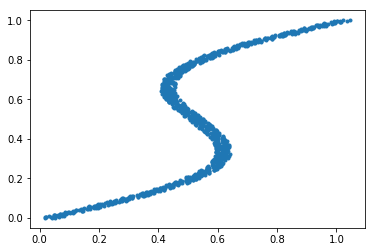

In [3]:
plt.plot(df.x, df.target, '.');

Normal regression approaches to modeling such a function wont work, as they expect the function to be a proper mathematical function, that is, single valued.

These kind of problems are called **inverse problems**, where more than one input state leads to an output state, and we have to try and model these multiple input states.

A mixture of gaussians (or other distributions) might is a sensible way to do this.

You choose one of the gaussians with some probability. The nean of the gaussian is then given by some regression function, say for example a straight line. We could additionally fix the standard deviation or model it as well. 

Thus, for each component Gaussian, we choose a functional form for the mean and standard deviation. So our model looks something like this:

$$f(x)  = \sum_i \lambda_i g_i (x) $$

Say we fit a model with 3 gaussians to this data. Such a model cannot fit the function above. Notice for example that at $x=0.2$ only one of the gaussians will dominate, different from the situation at $x=0.5$. This means that the probabilities of "belonging" to one or the other gaussians is also changing with $x$.

If we allow the mixing probabilities to depend on $x$, we can model this situation.

$$f(x)  = \sum_i \lambda_i (x) g_i (x) $$

Such a model is called a "mixture of experts" model. The idea is that one "expert" gaussian is responsible in one sector of the feature space, while another expert is responsible in another sector.

You can think of this model as implementing a "standard" gaussian mixture at each "point" x, with the added complexity that all of the means, standard deviations, and mixture probabilities change from one x to another.

See https://www.cs.toronto.edu/~hinton/absps/hme.pdf and http://www.ee.hacettepe.edu.tr/~eyuksel/Publications/2012_TwentyYearsofMixtureofExperts.pdf for more details. I found the latter clearer and easier to understand.

For this entire question you might find diagram code from [here](https://github.com/hardmaru/pytorch_notebooks/blob/master/mixture_density_networks.ipynb) useful. Take with attribution.

We will assume we have **3 gaussians**.

## PART A: Iterative Linear Regression

The basic idea, illustrated below, is to fit piecewise linear regressions iteratively in a EM style algorithm.

![](images/mixreg0.png)

The algorithm looks like this: initialize the 1000 points in this dataset as randomly belonging to one of 3 "classes" or "clusters" or "experts". This takes a x-data problem and augments it with a fake z data point that tells us whether the point belongs in cluster 0, 1, or 2. (It helps convergence to say that points in the leftmost 0.2 belong to cluster 0 and righmost 0.2 to cluster 2).

Once we have the fake z data we can separate out the 1000 points into 3 sets of points and fit 3 linear regression models. 

We can make predictions for all 1000 points on the data for each of the 3 regression lines. We now assign a data point to the cluster by calculating the squared distances between its actual y value and the 3 cluster predictions and choosing the smallest one.

We then rinse and repeat.

**A1** Implement this algorithm along with a convergence criterion of your choice

In [4]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import time

In [5]:
# Step 1: Initialize the points randomly with a z value
df['z'] = np.random.randint(0,3,size=(len(df)))

# Force initialization of the leftmost .2 and rightmost .2
df.loc[df.x < 0.3, 'z'] = 0
df.loc[df.x > 0.7, 'z'] = 2

# Step 2: Separate 1000 points into 3 sets of points and fit 3 regression models
cats = [0,1,2]

mse = np.ones((len(df), len(cats)))

mse_new = np.ones((len(df), 1))
mse_old = np.zeros((len(df), 1))

# Loop until convergence:
k=0
while np.abs((np.mean(mse_new) - np.mean(mse_old))/np.mean(mse_old)) > 1e-4:
    mse_old = mse_new
    regr = []

    for i, cat in enumerate(cats):
        # Create linear regression object
        regr.append(linear_model.LinearRegression())

        # Train the model on this category
        regr[i].fit(df.loc[df.z==cat, 'x'].values.reshape(-1, 1), df.loc[df.z==cat,'target'].values.reshape(-1, 1))

        # Step 3: Make predictions on all points for this line
        preds = regr[i].predict(df['x'].values.reshape(-1, 1))
        mse[:,i] = (1/2 * (df['target'].values - preds.reshape(1, -1))**2)

    # Step 3: Get the minimum value of the MSE and reassign the labels
    zvals = np.argmin(mse, axis=1)
    
    # Get the proper mse for comparison
    mse_new = mse[:, zvals]
                   
    # Reassign dataframe
    df['z'] = zvals
        
    # Count iterations
    k+=1

**A2** Produce a diagram like the one above which illustrates the straight line fits as well as the cluster belonging. 

In [6]:
print('Number of Iterations:', k)

Number of Iterations: 8


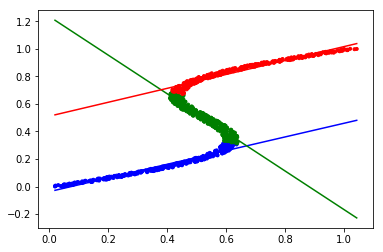

In [7]:
# Plot the output classes
colors = ['b','g','r']

cs = [colors[i] for i in df.z.values]

plt.scatter(df.x, df.target, marker='.', c=cs);
# Add regression lines
for cat in cats:
    plt.plot([df.x.min(), df.x.max()], [regr[cat].predict(df.x.min())[0][0], regr[cat].predict(df.x.max())[0][0]],
            c=colors[cat])
plt.plot()
plt.show()

## Part B: Variational Mixture of Experts

In this part we'll construct a gaussian mixture model of 3 "expert" linear regressions. The idea is to create a fit which looks like this:

![](images/mixreg.png)

Here again the three regression lines work in different regions of $f$. We want a principled way to sample from this model and to be able to produce posterior and posterior-predictive regions.

There are 3 parts to this model. First the means of the gaussians in the mixture are modeled with linear regression as shown in the picture above. We will also model $log(\sigma)$ for each gaussian in the mixture as a linear regression as well ($\sigma$ needs to be positive).

We now need to model the mixture probabilities, i.e., the probabilities required to choose one or the other gaussian. We'll model these probabilities i.e. the $\lambda$s using softmax regression (ie do a linear regression and softmax it to get 3 probabilities).

**B1** Write a pymc3 model for this problem. For all biases and weights in your regressions, assume N(0,5) priors. Add noise 0.01 to each of the three $\sigma$s to make sure you dont have a collapsed 0 width gaussian, ie we want some data in every cluster. (Thus to get the final $\sigma$, you will exponentiate your regression for $log(\sigma)$ and add 0.01.)

In [8]:
import theano.tensor as T

In [9]:
# Initial values
Nmix = 3
Npts = len(df)
data = df.x.values.reshape(-1,1)
targ = df.target.values.reshape(-1,1)

# The model
with pm.Model() as mix_exp_1:
    # Means
    w1 = pm.Normal('w1',0,5, shape=(1,Nmix))
    b1 = pm.Normal('b1',0,5, shape=(1,Nmix))
    means = pm.Deterministic('means', pm.math.dot(data,w1) + b1)
    
    # Log sigmas
    w2 = pm.Normal('w2',0,5, shape=(1,Nmix))
    b2 = pm.Normal('b2',0,5, shape=(1,Nmix))
    logsigs = pm.math.dot(data,w2) + b2
    sigmas = pm.Deterministic('sigmas',np.exp(logsigs) + 0.01)
    
    # Mixture probabilities
    w3 = pm.Normal('w3',0,5, shape=(1,Nmix))
    b3 = pm.Normal('b3',0,5, shape=(1,Nmix))
    mixprob = pm.Deterministic('mixprob', T.nnet.softmax(pm.math.dot(data,w3) + b3))
    
    # Likelihood model
    y_obs = pm.NormalMixture('y_obs', w=mixprob, mu=means, sd=sigmas, observed=targ)

**B2** Fit this model variationally for about 50,000 iterations using the adam optimizer. (`obj_optimizer=pm.adam()`) Plot the ELBO to make sure you have converged. Print summaries and traceplots for the means, $\sigma$s and probabilities.

In [10]:
# Sample from this model variationally:
advifit = pm.ADVI( model=mix_exp_1)
advifit.fit(n=50000, obj_optimizer=pm.adam())

Average Loss = -1,602.4: 100%|██████████| 50000/50000 [01:38<00:00, 508.13it/s]
Finished [100%]: Average Loss = -1,602.4


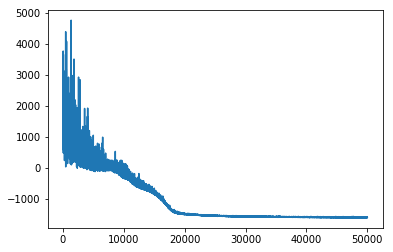

In [11]:
# Plot the ELBO
plt.plot(advifit.hist);
plt.show()

In [12]:
advifit.approx.shared_params, type(advifit.approx.shared_params)

({'mu': mu, 'rho': rho}, dict)

In [13]:
advifit.approx.mean.eval(), advifit.approx.std.eval()

(array([  8.42129129,  -9.71591737,  -0.23534055,  -4.91006545,
          4.4787229 ,   0.54145737,   0.57434378,  -0.02002836,
          1.33081379,   0.425454  ,   0.42640739,  -1.59240679,
        -12.11404041,  10.14664459,   1.43105904,   1.77445778,
        -10.16555455,  -4.30668142]),
 array([ 0.14346075,  0.19292257,  0.12949246,  0.0890743 ,  0.09128599,
         0.07063588,  0.00078231,  0.00079444,  0.00204914,  0.00099294,
         0.0023576 ,  0.00395616,  0.21230987,  0.27577437,  0.11084338,
         0.10295971,  0.1401846 ,  0.05885346]))

In [14]:
trace = advifit.approx.sample(10000)

In [15]:
trace.varnames

['w1', 'b1', 'w2', 'b2', 'w3', 'b3', 'means', 'sigmas', 'mixprob']

In [16]:
# Summaries and traceplots for a few
pm.summary(trace, varnames=['w1','b1','w2','b2','w3','b3'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5
w1__0_0,0.425439,0.000995,0.000010,0.423554,0.427455
w1__0_1,0.426380,0.002349,0.000021,0.421708,0.430920
w1__0_2,-1.592428,0.003939,0.000043,-1.600074,-1.584903
b1__0_0,0.574344,0.000789,0.000008,0.572836,0.575926
b1__0_1,-0.020028,0.000795,0.000009,-0.021523,-0.018440
b1__0_2,1.330817,0.002051,0.000022,1.326940,1.334872
w2__0_0,-12.113341,0.212809,0.002258,-12.553481,-11.718455
w2__0_1,10.150543,0.271712,0.002622,9.601837,10.675556
w2__0_2,1.431218,0.110547,0.001010,1.210006,1.639733
w3__0_0,8.421068,0.142586,0.001275,8.139811,8.697211


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c531504e0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1c2783f198>]], dtype=object)

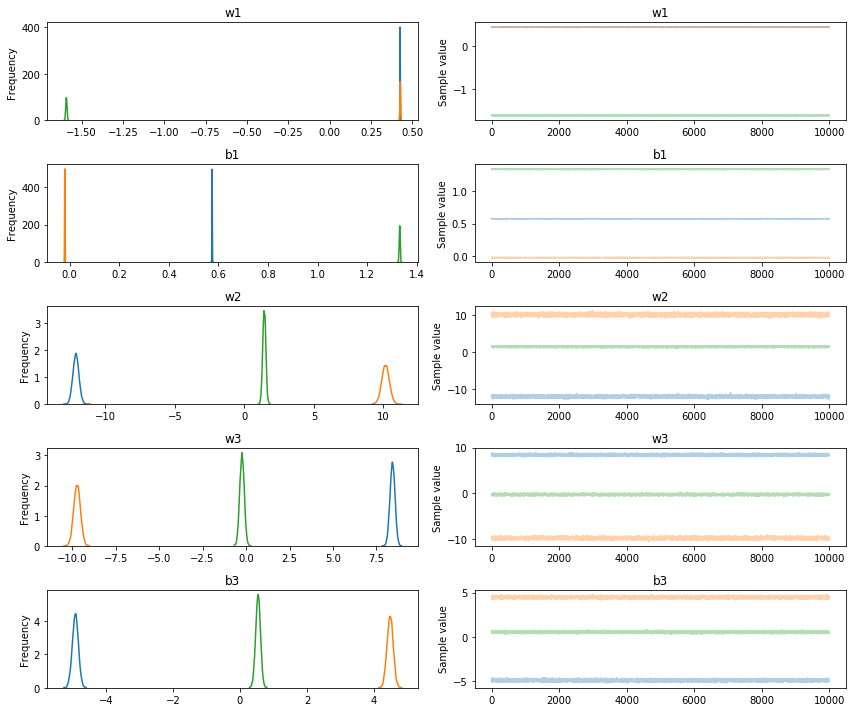

In [17]:
pm.traceplot(trace, varnames=['w1','b1','w2','w3','b3'])

**B3** Plot the mean posteriors with standard deviations against x. Also produce a diagram like the one above to show the means with standard deviations showing their uncertainty overlaid on the data.

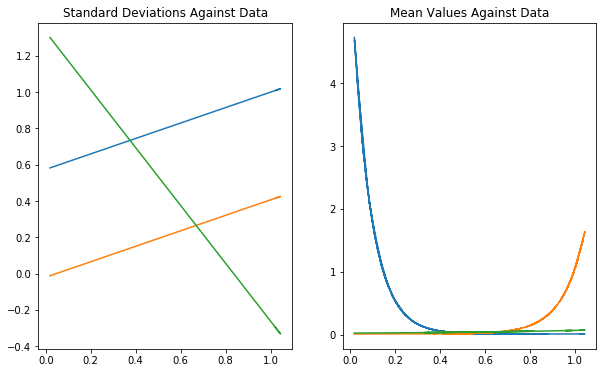

In [18]:
# Plotting mean posteriors and standard deviations against x
means_out = np.mean(trace['means'], axis=0).T
sigmas_out = np.mean(trace['sigmas'], axis=0).T

fig,ax = plt.subplots(1,2, figsize=(10,6))
ax[0].plot(df.x, means_out.T)
ax[0].set_title('Mean Values Against Data')
ax[1].plot(df.x, sigmas_out.T)
ax[1].set_title('Standard Deviations Against Data')
plt.show()

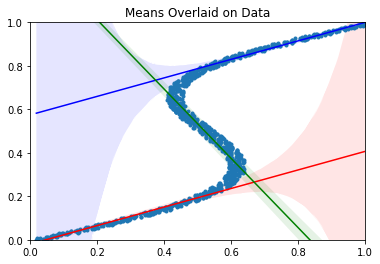

In [19]:
# Means with standard deviations showing their uncertainty overlaid on the data.
plt.plot(df.x, df.target, '.');
new_colors = ['b','r','g']
for cat in cats:
    plt.plot(df.x, means_out[cat,:], c=new_colors[cat])
    plt.fill_between(df.x, means_out[cat,:] + sigmas_out[cat,:], means_out[cat,:] - sigmas_out[cat,:], 
                     facecolor=new_colors[cat], alpha=0.1)
plt.ylim([0,1.0])
plt.xlim([0,1.0])
plt.title('Means Overlaid on Data')
plt.show()

**B4** Plot the posterior predictive (mean and variance) as a function of x for this model (using `sample_ppc` for example). Why does the posterior predictive look nothing like the data?

In [20]:
# Get ppc samples
with mix_exp_1:
    traces_ppc = pm.sample_ppc(trace, samples=5000)

100%|██████████| 5000/5000 [02:50<00:00, 29.41it/s]


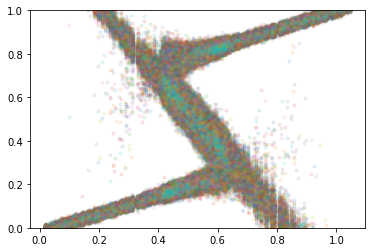

In [22]:
plt.plot(df.x, traces_ppc['y_obs'][::10,:].T, '.', alpha=.1)
plt.ylim([0,1.0])
plt.show()

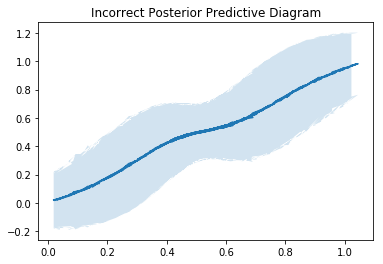

In [23]:
# Plotting the posterior predictive
plt.plot(df.x, traces_ppc['y_obs'].mean(axis=0))
plt.fill_between(df.x, traces_ppc['y_obs'].mean(axis=0) + traces_ppc['y_obs'].std(axis=0),
                       traces_ppc['y_obs'].mean(axis=0) - traces_ppc['y_obs'].std(axis=0),
                    alpha=0.2)
plt.title('Incorrect Posterior Predictive Diagram')
plt.show()

The reason that this posterior predictive is incorrect is because, predictions are not able to provide a one-to-many output for the ppc samples. It only draws one value at a time for each value of x. As a result, the mean value of the regions where the function behaves as a one-to-many will be the mean of the "many" and will exist somewhere in the middle. As a result, there is no way to get the one-to-many behavior.

**B5** Make a "correct" posterior predictive diagram by taking into account which "cluster" or "regression line" the data is coming from. To do this you will need to sample using the softmax probabilities. A nice way to do this is "Gumbel softmax sampling". See http://timvieira.github.io/blog/post/2014/07/31/gumbel-max-trick/ for details. Color-code the predictive samples with the gaussian they came from. Superimpose the predictive on the original data. This diagram may look something like this:

![](images/mixpred.png)

In [24]:
# Perform Gumbel softmax sampling. 
# Algorithm extracted from: http://timvieira.github.io/blog/post/2014/07/31/gumbel-max-trick/
def gumbel_max_sample(x):
    '''x here is the pre-softmax weighting'''
    z = np.random.gumbel(loc=0, scale=1, size=x.shape)
    return (x + z).argmax(axis=1)

In [116]:
# Sample pre-softmax weighting using Gumbel Max
idx = np.random.randint(len(trace))
pin = np.dot(data.reshape(-1,1), trace[idx]['w3']) + trace[idx]['b3']
cat_samples = gumbel_max_sample(pin)

In [117]:
# Based on the category, pick the associated mean and sigma then sample from normal
means_samp = trace[idx]['means'][np.arange(len(cat_samples)),cat_samples]
sigmas_samp = trace[idx]['sigmas'][np.arange(len(cat_samples)),cat_samples]
data = np.random.normal(loc=means_samp, scale=sigmas_samp)

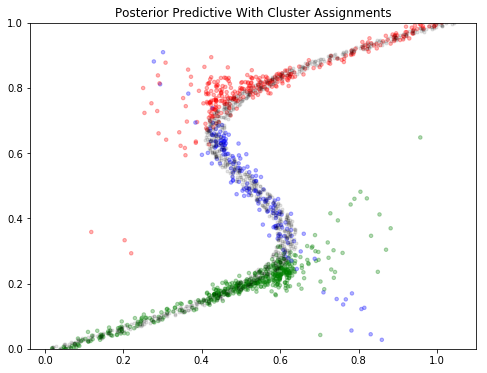

In [118]:
colors = ['r','g','b']
col = [colors[i] for i in cat_samples]

# Make the plot
fig = plt.figure(figsize=(8,6))
plt.plot(df.x, df.target, 'k.', alpha=.1);
plt.scatter(df.x, data, s=50, marker='.', color=col, alpha=.3 )
plt.ylim([0,1.0])
plt.title('Posterior Predictive With Cluster Assignments')
plt.show()

## Part C. Mixture Density Network

A mixture density network (see the enclosed Chapter 5 excerpt from Bishop or https://publications.aston.ac.uk/373/1/NCRG_94_004.pdf) is very closely related to the mixture of experts model. The difference is that we fit the regressions using a neural network where hidden layers are shared amongst the mean, sigma, and mixing probability regressions. (We could have fit 3 separate neural networks in Part A but opted to fit linear regressions for simplicity)

(More explanation [here](https://github.com/hardmaru/pytorch_notebooks/blob/master/mixture_density_networks.ipynb). You are welcome to take code from here with attribution.)

You job here is to construct a multi-layer perceptron model with a linear hidden layer with 20 units followed by a `Tanh` activation. After the activation layer, 3 separate linear layers with `n_hidden` inputs and `n_gaussian=3` outputs will complete the network. The probabilities part of the network is then passed through a softmax. The means part is left as is. The sigma part is exponentiated and 0.01 added, as in part A

Thus the structure looks like:

```
input:1 --linear-> n_hidden -> Tanh --linear-->n_gaussians      ...mu
                            --linear-->n_gaussians->softmax     ...lambda
                            --linear-->n_gaussians->exp + 0.01  ...sigma
```

We then need to use a loss function for the last layer of the network. 

Using the mean-squared-error loss is not appropriate as the expected value of samples drawn from the sampling distribution of the network will not reflect the 3-gaussian structure (this is the essence of the difference between B4 and B5 above). Thus we'll use the negative loss likelihood of the gaussian mixture model explicitly.

**C1**: Write the network as a class `MixtureDensityNetwork` which inherits from pytorch `nn.Module`. Implement a constructor which allows at-least the number of hidden layers to be varied. Also implement the `forward` method.

In [28]:
import torch
import torch.nn as nn 
from torch.autograd import Variable

In [29]:
# CITATION: Code taken from the link provided above: 
# https://github.com/hardmaru/pytorch_notebooks/blob/master/mixture_density_networks.ipynb
class MixtureDensityNetwork(nn.Module):
    def __init__(self, n_hidden, n_gaussians):
        super(MixtureDensityNetwork, self).__init__()
        self.z_h = nn.Sequential(
            nn.Linear(1, n_hidden),
            nn.Tanh()
        )
        self.z_pi = nn.Linear(n_hidden, n_gaussians)
        self.z_sigma = nn.Linear(n_hidden, n_gaussians)
        self.z_mu = nn.Linear(n_hidden, n_gaussians)  

    def forward(self, x):
        z_h = self.z_h(x)
        pi = nn.functional.softmax(self.z_pi(z_h), -1)
        sigma = torch.exp(self.z_sigma(z_h))
        mu = self.z_mu(z_h)
        return pi, sigma, mu

In [30]:
# Implement cost functions from: 
# https://github.com/hardmaru/pytorch_notebooks/blob/master/mixture_density_networks.ipynb
oneDivSqrtTwoPI  = 1.0 / np.sqrt(2.0*np.pi) # normalization factor for Gaussians
def gaussian_distribution(y, mu, sigma):
    # make |mu|=K copies of y, subtract mu, divide by sigma
    result = (y.expand_as(mu) - mu) * torch.reciprocal(sigma)
    result = -0.5 * (result * result)
    return (torch.exp(result) * torch.reciprocal(sigma)) * oneDivSqrtTwoPI

def mdn_loss_fn(pi, sigma, mu, y):
    result = gaussian_distribution(y, mu, sigma) * pi
    result = torch.sum(result, dim=1)
    result = -torch.log(result)
    return torch.mean(result)

In [31]:
network = MixtureDensityNetwork(n_hidden=20, n_gaussians=3)

In [32]:
xdata = np.float32(df.x.values.reshape(-1,1))
ydata = np.float32(targ)

xtensor = torch.from_numpy(xdata)
ytensor = torch.from_numpy(ydata)

xvariable = Variable(xtensor)
yvariable = Variable(ytensor, requires_grad=False)

**C2**: Train the network using the Adam or similiar optimizer. Make sure your loss converges and plot this convergence.

In [33]:
optimizer = torch.optim.Adam(network.parameters())

In [34]:
# Training functions 
def train_MDN(epochs):
    loss_accum = []
    for epoch in range(epochs):
        pi_variable, sigma_variable, mu_variable = network(xvariable)
        loss = mdn_loss_fn(pi_variable, sigma_variable, mu_variable, yvariable)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_accum.append(loss.data[0])
        if epoch % 500 == 0:
            print(epoch, loss.data[0])
    return loss_accum

loss_accum = train_MDN(epochs=5000)

0 1.189703106880188
500 -0.19451577961444855
1000 -1.8210179805755615
1500 -1.9260978698730469
2000 -1.942816972732544
2500 -1.950843334197998
3000 -1.958014726638794
3500 -1.9631280899047852
4000 -1.970958948135376
4500 -1.9794083833694458


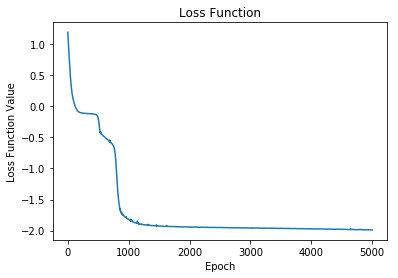

In [35]:
# Plot loss function:
plt.plot(loss_accum)
plt.title('Loss Function')
plt.xlabel('Epoch')
plt.ylabel('Loss Function Value')
plt.show()

**C3**: Plot the MLE parameters against x. Make a plot similar to B3 above where you overlay the "means" of the gaussians against the data.

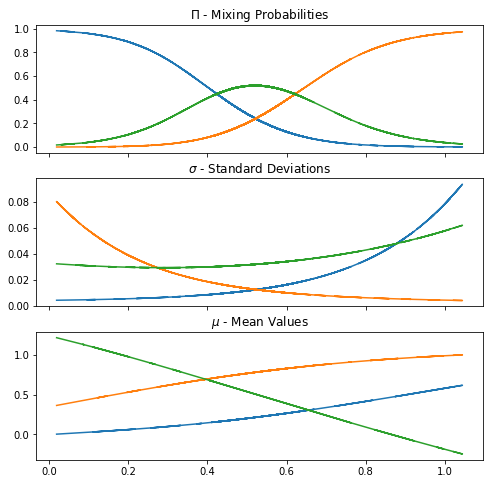

In [36]:
pi_variable, sigma_variable, mu_variable = network(xvariable)

pi_data = pi_variable.data.numpy()
sigma_data = sigma_variable.data.numpy()
mu_data = mu_variable.data.numpy()

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(8,8))
ax1.plot(xdata, pi_data)
ax1.set_title('$\Pi$ - Mixing Probabilities')
ax2.plot(xdata, sigma_data)
ax2.set_title('$\sigma$ - Standard Deviations')
ax3.plot(xdata, mu_data)
ax3.set_title('$\mu$ - Mean Values')
plt.show()

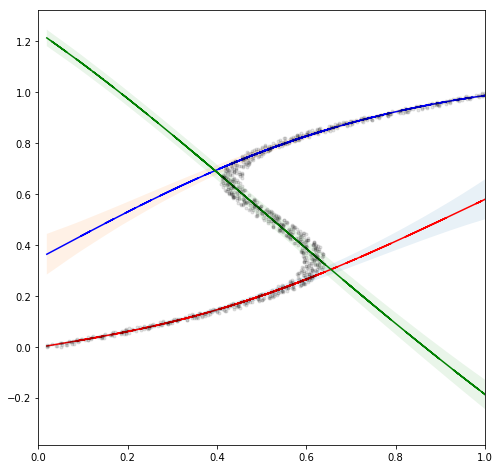

In [40]:
# Make plot like B3
colors = ['r','b','g']
plt.figure(figsize=(8, 8), facecolor='white')
for i, (mu_k, sigma_k) in enumerate(zip(mu_data.T, sigma_data.T)):
    plt.plot(xdata.reshape(-1), mu_k, c=colors[i])
    plt.fill_between(xdata.reshape(-1), mu_k-sigma_k, mu_k+sigma_k, alpha=0.1)
plt.plot(df.x, df.target, 'k.', alpha=0.1)
plt.xlim([0.0,1.0])
plt.show()

**C4**: Sample from the sampling distributions to make a plot similar to B5 above

In [41]:
# Define another gumbel sample by taking the log of the input weight probability
def gumbel_sample(x, axis=1):
    z = np.random.gumbel(loc=0, scale=1, size=x.shape)
    return (np.log(x) + z).argmax(axis=axis)

In [44]:
# Get samples
n_samples = len(df.x)
k = gumbel_sample(pi_data)
indices = (np.arange(n_samples), k)
rn = np.random.randn(n_samples)
sampled = rn * sigma_data[indices] + mu_data[indices]

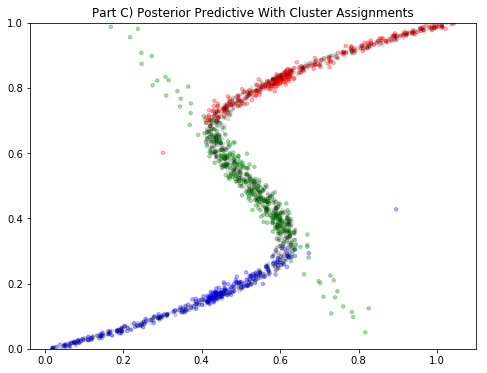

In [49]:
col = [new_colors[i] for i in k]

# Make the plot
fig = plt.figure(figsize=(8,6))
plt.plot(xdata, ydata, 'k.', alpha=.1);
plt.scatter(xdata, sampled, s=50, marker='.', color=col, alpha=.3 )
plt.ylim([0,1.0])
plt.title('Part C) Posterior Predictive With Cluster Assignments')
plt.show()

**To think about but not to hand in** What are the differences between a mixture density network and the mixture of experts. How do these differences translate to feature space? What would happen if we took the shared hidden layer nonlinearity (Tanh) out?

**NEED ANSWER**

## Part D Variational Mixture Density Network

We want to implement the Mixture Density Metwork model that we constructed in Part C in directly in pymc3 and use variational inference to sample from it. We  may need more iterations in order to get convergence as this model will likely not converge as fast as the pytorch equivalent.

**D1**: Write out the equivalent pymc3 version of the MDN and generate posterior samples with ADVI.

In [54]:
# Pytorch network model
print(network)

MixtureDensityNetwork(
  (z_h): Sequential(
    (0): Linear(in_features=1, out_features=20)
    (1): Tanh()
  )
  (z_pi): Linear(in_features=20, out_features=3)
  (z_sigma): Linear(in_features=20, out_features=3)
  (z_mu): Linear(in_features=20, out_features=3)
)


Reminder that

the structure looks like:

```
input:1 --linear-> n_hidden -> Tanh --linear-->n_gaussians              ...mu
                                    --linear-->n_gaussians->softmax     ...lambda
                                    --linear-->n_gaussians->exp + 0.01  ...sigma
```

In [81]:
n_hidden=20 # Number of hidden neurons
n_gaussians=3
with pm.Model() as nn_mixture:
    # Weights from input to hidden layer
    w1 = pm.Normal('w1', 0, 5, shape=(xdata.shape[1],n_hidden) )
    b1 = pm.Normal('b1', 0, 5, shape=(1,n_hidden))
    layer_1 = pm.math.tanh( pm.math.dot(xdata, w1) + b1 )
    
    # Weights from hidden to output for mean
    w_m = pm.Normal('w_m', 0, 5, shape=(n_hidden,n_gaussians) )
    b_m = pm.Normal('b_m', 0, 5, shape=(1,n_gaussians))
    
    # Weights for log sigma
    w_s = pm.Normal('w_s', 0, 5, shape=(n_hidden,n_gaussians) )
    b_s = pm.Normal('b_s', 0, 5, shape=(1,n_gaussians))
        
    # Weights for mixing probabilities
    w_p = pm.Normal('w_p', 0, 5, shape=(n_hidden,n_gaussians) )
    b_p = pm.Normal('b_p', 0, 5, shape=(1,n_gaussians))
    
    # Getting mu
    mu = pm.Deterministic('mu', pm.math.dot( layer_1, w_m ) + b_m)
    
    # Getting sigma matrix
    sig = pm.Deterministic('sig', pm.math.exp( pm.math.dot(layer_1,w_s)+b_s)+.01)
    
    # Getting mixing probabilities
    pmix = pm.Deterministic('pmix', T.nnet.softmax(pm.math.dot(layer_1,w_p)+b_p))
    
    # Y observed likelihood
    y_obs = pm.NormalMixture('y_obs', w=pmix, mu=mu, sd=sig, observed=ydata)

**D2**: Sample from the posterior predictive as you did in B4 and produce a diagram like C4 and B5 for this model.

In [82]:
# Sample from this model variationally:
advifit_2 = pm.ADVI( model=nn_mixture)
advifit_2.fit(n=150000, obj_optimizer=pm.adam())

Average Loss = -1,291.3: 100%|██████████| 150000/150000 [06:56<00:00, 360.10it/s]
Finished [100%]: Average Loss = -1,291.5


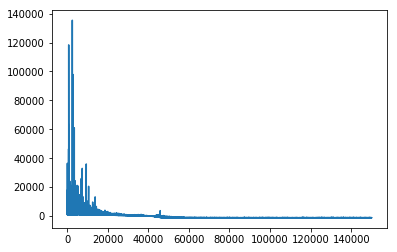

In [83]:
# Show ELBO plot for convergence
plt.plot(advifit_2.hist);
plt.show()

In [84]:
trace_2 = advifit_2.approx.sample(10000)

In [85]:
# Get ppc samples
with nn_mixture:
    traces_ppc_2 = pm.sample_ppc(trace_2, samples=5000)

100%|██████████| 1000/1000 [00:30<00:00, 32.71it/s]


In [124]:
# Sample pre-softmax weighting using Gumbel Max
pin = np.exp(trace_2['pmix'])
cat_samples = gumbel_max_sample(pin)

In [125]:
# Sample pre-softmax weighting using Gumbel Max
idx = np.random.randint(len(trace))
pin_2 = np.dot(data.reshape(-1,1), trace[idx]['w3']) + trace[idx]['b3']
cat_samples = gumbel_max_sample(pin_2)

# Based on the category, pick the associated mean and sigma then sample from normal
means_samp_2 = trace[idx]['means'][np.arange(len(cat_samples)),cat_samples]
sigmas_samp_2 = trace[idx]['sigmas'][np.arange(len(cat_samples)),cat_samples]
ydata_2 = np.random.normal(loc=means_samp, scale=sigmas_samp)

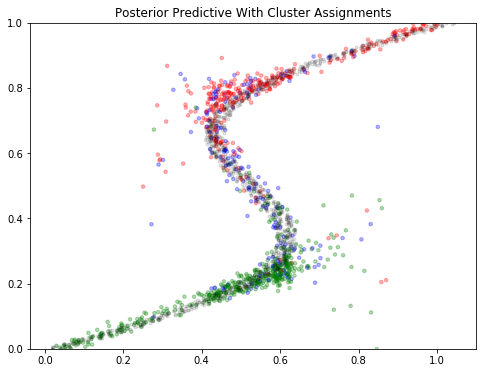

In [126]:
colors = ['r','g','b']
col = [colors[i] for i in cat_samples]

# Make the plot
fig = plt.figure(figsize=(8,6))
plt.plot(xdata, ydata, 'k.', alpha=.1);
plt.scatter(xdata, ydata_2, s=50, marker='.', color=col, alpha=.3 )
plt.ylim([0,1.0])
plt.title('Posterior Predictive With Cluster Assignments')
plt.show()

**D3**: Plot the "mean" regression curves (similar to C3 and B3). Do the "mean" regression curves in this model look the same from those in Part C?  If they differ why so?

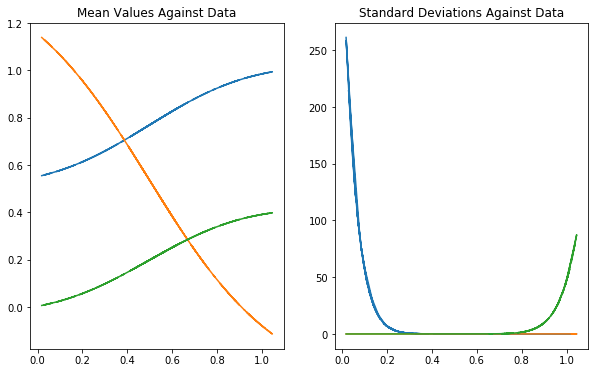

In [132]:
# Plotting mean posteriors and standard deviations against x
means_out_2 = np.mean(trace_2['mu'], axis=0).T
sigmas_out_2 = np.mean(trace_2['sig'], axis=0).T

fig,ax = plt.subplots(1,2, figsize=(10,6))
ax[0].plot(xdata, means_out_2.T)
ax[0].set_title('Mean Values Against Data')
ax[1].plot(xdata, sigmas_out_2.T)
ax[1].set_title('Standard Deviations Against Data')
plt.show()

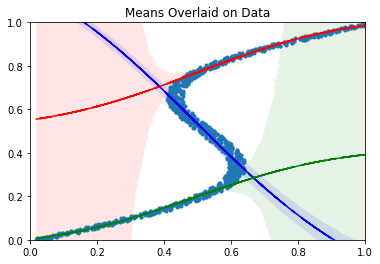

In [134]:
# Means with standard deviations showing their uncertainty overlaid on the data.
plt.plot(xdata, ydata, '.');
new_colors = ['r','b','g']
for cat in cats:
    plt.plot(xdata, means_out_2[cat,:], c=new_colors[cat])
    plt.fill_between(df.x, means_out_2[cat,:] + sigmas_out_2[cat,:], means_out_2[cat,:] - sigmas_out_2[cat,:], 
                     facecolor=new_colors[cat], alpha=0.1)
plt.ylim([0,1.0])
plt.xlim([0,1.0])
plt.title('Means Overlaid on Data')
plt.show()

## Part E: Approximate EM for model in part B (EXTRA CREDIT)

Part B can be implemented using Expectation Maximization using iteratively-reweighted least squares. Our method in A was merely an approximation to this process. You can find update equations [here](https://people.eecs.berkeley.edu/~jordan/papers/jordan-xu.ps)